
# Flow Matching

To reduce the many function evaluations of DDPM, we'll turn to _flow matching_ {cite}`lipman2022flow`. To motivate the transition from denoising to flow matching, the score formulation from {eq}`score-perturbed` comes in handy: as a reminder, there we were integrating the gradient $\nabla_x$ of the log likelihoods to transform noise into a target distribution over the course of a continuous virtual time axis. To briefly re-cap, we integrated $\nabla_{\tilde{x}} \log p_\sigma(\tilde{x})$ over time with Langevin dynamics
$dx/dt = \epsilon \nabla_x \log p(x) + \sqrt{2 \epsilon} z_i $, and used a training objective of $\arg \min_\theta \mathbb{E} \left[ || s_\theta(\tilde{x}) - \nabla_{\tilde{x}} \log p_\sigma(\tilde{x}) ||^2 \right]$ to learn the score $s_\theta(\tilde{x})$. Score modeling leveraged the mathematical equivalence between the probability flows of diffusion processes and the trajectories of probability densities in the form of ordinary differential equations (ODEs).

## Learning Flows with Velocities

Flow-matching是估计速度场，而 score matching估计的这个梯度，就可以被视为速度场。

For _flow matching_, our goal is to construct a _flow_ in a velocity field, and
the gradients in score matching can actually readily be interpreted as a _velocity_: neglecting the stochastic terms of the Langevin time evolution above, we're left with the velocity $dx/dt = \nabla_x \log p(x)$ of $x$ being the score. The main challenge we were fighting with in the context of score matching was how to obtain a good reference velocity, so that we could train a neural network.

Now, with the powerful machinery of _denoising_ at hand, we can revisit the  concept of _flows and velocities_: we aim for learning a continuous-time flow, for which we prescribe as-simple-as-possible reference velocities. As before, the velocity viewpoint frees us from any constraints on the network architecture, and the simple velocities will make training and inference substantially faster than before.

Let's formalize this: methods such as _flow matching_ are typically categorized as "continuous-time flow models", and transform samples $x$ from a sampling distribution $p_0$ to samples of a target or posterior distribution $p_1$. This mapping is expressed via the ODE

$$
    dx/dt = v_\theta(x,t) ,
$$

where $v_\theta(x,t)$ represents a neural network with parameters $\theta$. In flow matching, the network $v_\theta$ is trained by regressing a vector field that generates probability paths that map from $p_0$ to $p_1$.

We say that a smooth vector field $u : [0,1] \times \mathbb{R}^d \to \mathbb{R}^d$, called _velocity_, generates the probability paths $p_t$, if it satisfies the continuity equation $\partial p / \partial t = - \nabla \cdot (p_t u_t)$.
Informally, this means that we can sample from the distribution $p_t$ by sampling $x_0 \sim p_0$ and then solving the ODE $dx = u(x,t)dt$ with initial condition $x_0$. In the following, we will denote $u(x,t)$ by $u_t(x)$.
To regress the velocity field, we define the _flow matching_ objective

$$
\begin{aligned}
    \mathcal{L}_\mathrm{FM}(\theta) = \mathbb{E}_{t\sim \mathcal{U}(0,1), x \sim p_t(x)} ~||~ v_\theta(x,t) - u_t(x)
    ~||^2.
\end{aligned}
$$ (eq-flow-matching)

这里就是把流匹配的物理概念和分数匹配的数学概念对应起来了，之前是用概率梯度移动采样点，采样点多的地方就是分布中心，现在是用速度移动位置点，位置点不同时刻的位置就是流场中测点的位置。

In order to evaluate this loss, we need to sample from the probability distribution $p_t(x)$ and we need to know the velocity $u_t(x)$.
In contrast to the perturbed data that we used for score matching, we'll solve this problem differently for flow matching:
we apply a trick by introducing a latent variable $z$ distributed according to $q(z)$ and define the conditional likelihoods $p_t(x|z)$ that depend on the latent variable so that $p_t(x) = \int p_t(x|z)q(z)dz$. Interestingly, if the conditional likelihoods are generated by the velocities $u_t(x|z)$, then the velocity $u_t(x)$
can be expressed in terms of $u_t(x|z)$ and $p_t(x|z)$ as the following expectation:
$u_t(x) = \mathbb{E}_{q(z)}[u_t(x|z)p_t(x|z)/p_t(x)]$.
Here we have the freedom to choose paths $p_t(x|z)$ that are easy to sample from and for which we know the generating velocities $u_t(x|z)$.
So, as long as we can generate enough velocities conditioned on $z$, we can obtain the expectation over the course of producing all these samples, and obtain the right generating velocity for training our network.

Flow networks can then be trained with the _conditional flow matching_ loss

$$
\begin{aligned}
    \mathcal{L}_\mathrm{CFM}(\phi) = \mathbb{E}_{q(z,t),p_t(x|z)} ~||~ v_\phi(x,t)-u_t(x|z) ~||^2.
\end{aligned}
$$ (conditional-flow-matching)

This version is tractable and can be used for actual training runs, in contrast to the un-conditional objective from equation {eq}`eq-flow-matching`.
This means that we can train $v_\theta(x,t)$ to regress $u_t(x)$ generating the mapping from $p_0$ to the target distribution $p_1$.

![Divider](https://github.com/tum-pbs/pbdl-book/blob/master/resources/divider-gen7.jpg?raw=1)

## Mappings and Conditioning

Especially important: we have a lot of freedom when specifying the mapping from $p_0$ to $p_1$ via the conditioning variable $z$ and the conditional likelihoods $p_t$ in this formulation.
So how do we best make use of this freedom?
It turns out, the "simplest possibility" of aiming for straight, non-crossing paths is a great choice. The goal is a velocity from the current state $x$ directly towards the target $x_1$ at time $t$ with
$(x_1-x) / (1-t)$. The only slight complication is that we need to consider a minimal amount of noise $\sigma_\mathrm{min} > 0$ at time $t=1$ to ensure that despite having discrete samples, we keep a continuous distribution. This aspect is in line with the perturbed samples from score matching above. Hence $\sigma_\mathrm{min}$ influences the end points of the prescribed paths and its probability distribution.

Plugging it into the equations, we consider the coupling $q(z) = p_1(x)$  together with conditional probability and generating velocity

$$
\begin{aligned}
    p_t(x|x_1) &= \mathcal{N}( t x_1, (1-(1-\sigma_\mathrm{min})t)I) \\
    u_t(x|x_1) &= \frac{x_1-(1-\sigma_\mathrm{min})x}{1-(1-\sigma_\mathrm{min})t} ~.
\end{aligned}
$$ (conditional_ot_prob)

这里说的意思是，之前去噪是逐步去噪的，每次预测的是当前噪声下，样本点的运动方向，而这里，输入仍然是噪声输入，但是输出的是样本点到无噪声真值的运动方向。

Conditioned on $x_1$, this coupling transports a point $x_0 \sim \mathcal{N}(0,I)$ from the sampling distribution to the posterior distribution on the linear trajectory $t x_1$ ending in $x_1$. At the same time it decreases the standard deviation from $1$ to a smoothing constant $\sigma_\mathrm{min}$. In this case, the transport path coincides with the optimal transport between two Gaussian distributions.

So it might seem - on first sight - that we've made a huge step back: we're back to transforming distributions, a concept for which we argued above in the section on _normalizing flows_ that it was a bad idea. However, with the methodology from score matching and denoising we've arrived at a fundamentally different (and more powerful) way to transform distributions. E.g., we're freed from constraints to preserve densities, and have a very tractable and convenient learning objective. In contrast to _Neural-ODEs_ we can train with single steps, instead of having to backpropagate through the full chain from end to start.

这里说的意思是，Score-Matching必须是高斯扩散，所以学习的目标必须是高斯过程的梯度，这就会带来一个限制，其隐空间只会向高斯梯度映射，因而不能直接指向目标。

Flow-Matching虽然每次还是以噪声数据输入，但是去掉了高斯分布假设，而是直接指向目标点，这就避免了次优收敛速度。

Flow-Matching可以这样做，是因为有流体显式建模，其关键在于，** 对于给定的初始分布 $p_0$ 和目标分布 $p_1$，存在无穷多个速度场 $u_t(x)$ 都能实现这个变换！ **


```{figure} resources/prob03-fm.jpg
---
height: 240px
name: probmod-fm
---
Flow matching (in contrast to CNFs and DDPMs): the simple base distribution (left) is transfored by ODE integration of the inferred flow velocity to obtain a sample from the target distribution (right). Due to the linear paths, only very few integration steps are necessary.
```

In addition, a fundamental advantage of flow matching over denoising diffusion models comes from a smart choice of the generating velocity paths: aiming for a linear velocity towards the target means we would obtain a straight path from an original sample towards our goal point. **Linear** here means that we could take a **single** Euler step to compute it from any starting point! As illustrated in the picture right above, this stands in huge contrast to the hundreds of steps we might have to make to follow one of the curved (unconstrained) denoising paths. It turns out we don't always obtain perfectly straight paths, so a single step can be sub-optmial (or might require further fine tuning / distillation of the flows). Nonetheless, flow matching typically works with a substantially reduced number of iterations compared to denoising. As inference time is directly proportional to the number of steps, this will result in a corresponding speed up when computing a sample from our posterior distribution. And, most importantly, we've not sacrificied any of the original goals: a convenient sampling procedure and an accurate coverage of the posterior just from data.


## Implementing Flow Matching

Just like for DDPM, we first need to initialize our standard Gaussian Mixture (GM) case:

In [1]:
import numpy as np

class GaussianMixture:
    def __init__(self, parameters):
        self.parameters = parameters
        self.distributions = [
            {
                'mean': np.array(dist['mean']),
                'std': np.array(dist['std']),
                'cov': np.diag(np.array(dist['std']) ** 2)
            }
            for dist in parameters
        ]

    def sample(self, num_samples):
        samples = []
        num_distributions = len(self.distributions)
        for _ in range(num_samples):
            idx = np.random.randint(num_distributions)  # Choose a random Gaussian
            dist = self.distributions[idx]
            sample = np.random.multivariate_normal(mean=dist['mean'], cov=dist['cov'])
            samples.append(sample)
        return np.array(samples)

parameters = [
    {"mean": [0, 0], "std": [1, 1]},
    {"mean": [3, 2], "std": [0.5, 0.5]}
]
mixture = GaussianMixture(parameters)

Setting up the training dataset is even simpler than for the denoising task. We don't need to include a noising schedule, but rather, we simply compute a straight velocity `u_t` for each requested sample after selecting a random time `t`.

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class FlowMatchingDataset(Dataset):
    def __init__(self, mixture, n_samples=1000, sigma_min=1e-4):
        super().__init__()
        self.n_samples = n_samples
        self.mixture = mixture
        self.sigma_min = sigma_min
        self.x1 = mixture.sample(n_samples)

    def __len__(self):
        return self.n_samples

    def __getitem__(self, idx):

        x0 = np.random.multivariate_normal([0.0, 0.0], np.eye(2), 1)[0]
        t = 2 * np.random.rand()  # scalar in [0,1]
        x1 = self.x1[idx]

        x_t = (1 - ( 1 - self.sigma_min) * t) * x0 + t * x1
        u_t = (x1 - x0)
        x_t = torch.tensor(x_t, dtype=torch.float32)
        t = torch.tensor([t], dtype=torch.float32)
        u_t = torch.tensor(u_t, dtype=torch.float32)

        return x_t, t, u_t


Similar to before, we'll use a simple neural network with three layers as "backbone" for the flow matching task:

In [11]:
class VelocityNet(nn.Module):
    def __init__(self, in_dim=2, time_dim=1, hidden_dim=128, out_dim=2):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim + time_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, out_dim)
        )

    def forward(self, x, t):
        xt = torch.cat([x, t], dim=1)
        return self.net(xt)


### Training a Velocity Model

Now we can start training the velocity model. This means with simply let the network predict the "supervised" ground truth velocity we receive from the dataset class. Just like for denoising, we have a very well-defined and stable learning task. The code cell below runs this training for 50 epochs:

In [12]:
n_samples = 10000
batch_size = 128
n_epochs = 50
learning_rate = 1e-3

dataset = FlowMatchingDataset(mixture, n_samples=n_samples)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

model = VelocityNet().to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.MSELoss()

for epoch in range(n_epochs):
    running_loss = 0.0
    for x_t, t, u_t in dataloader:
        x_t = x_t.to(device)
        t = t.to(device)
        u_t = u_t.to(device)
        optimizer.zero_grad()
        pred_v = model(x_t, t)
        loss = criterion(pred_v, u_t)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * x_t.size(0)
    running_loss /= len(dataset)
    print(f"Epoch {epoch + 1}/{n_epochs}, Loss: {running_loss:.4f}")


Epoch 1/50, Loss: 2.0892
Epoch 2/50, Loss: 1.5537
Epoch 3/50, Loss: 1.4433
Epoch 4/50, Loss: 1.4159
Epoch 5/50, Loss: 1.3764
Epoch 6/50, Loss: 1.3689
Epoch 7/50, Loss: 1.3544
Epoch 8/50, Loss: 1.3352
Epoch 9/50, Loss: 1.3469
Epoch 10/50, Loss: 1.3238
Epoch 11/50, Loss: 1.3288
Epoch 12/50, Loss: 1.3217
Epoch 13/50, Loss: 1.3184
Epoch 14/50, Loss: 1.3080
Epoch 15/50, Loss: 1.2913
Epoch 16/50, Loss: 1.2842
Epoch 17/50, Loss: 1.2755
Epoch 18/50, Loss: 1.2760
Epoch 19/50, Loss: 1.2870
Epoch 20/50, Loss: 1.2700
Epoch 21/50, Loss: 1.2757
Epoch 22/50, Loss: 1.2465
Epoch 23/50, Loss: 1.2645
Epoch 24/50, Loss: 1.2362
Epoch 25/50, Loss: 1.2817
Epoch 26/50, Loss: 1.2723
Epoch 27/50, Loss: 1.2486
Epoch 28/50, Loss: 1.2735
Epoch 29/50, Loss: 1.2620
Epoch 30/50, Loss: 1.2396
Epoch 31/50, Loss: 1.2495
Epoch 32/50, Loss: 1.2580
Epoch 33/50, Loss: 1.2479
Epoch 34/50, Loss: 1.2800
Epoch 35/50, Loss: 1.2476
Epoch 36/50, Loss: 1.2864
Epoch 37/50, Loss: 1.2590
Epoch 38/50, Loss: 1.2377
Epoch 39/50, Loss: 1.

### Inference via Solving the ODE

At inference time, we actually only have to integrate the velocities produced by the network starting from a random sample. While this could be done with simple Euler steps, we'll again use the ODE solvers from the `torchdiffeq` package for additional flexibility. (Feel free to experiment with other integration schemes below.)

In [13]:
try:
    import google.colab  # only to ensure that we are inside colab
    %pip install --quiet torchdiffeq
except ImportError:
    print("This notebook is running locally, please install torchdiffeq manually.")

The integration itself is done in `odeint` using the trained network in the `ode_func` wrapper. By default, we're integrating the trajectories over 100 steps, but in practice, much fewer should still give good results. Nonetheless, this is also an order of magnitude less that what we used for the DDPM version.

In [14]:
import torch
from torchdiffeq import odeint

def integrate_flow(model, x0, t_span=(0.0, 1.0), n_steps=100, method='dopri5'):

    t = torch.linspace(t_span[0], t_span[1], n_steps).to(x0.device)

    def ode_func(t, x):
        t_tensor = t.expand(x.shape[0], 1)
        return model(x, t_tensor)

    trajectory = odeint(ode_func, x0, t, method=method,
                        atol=1e-5, rtol=1e-5)

    return trajectory, t

n_gen = 500

x0_gen = torch.randn(n_gen, 2).to(device)
trajectory, time_points = integrate_flow(model, x0_gen)


### Visualize the Sampling Trajectories

We start with points from a standard gaussian, and color them based on their initial position. The plots below again show states at six different times of the  trajectories.

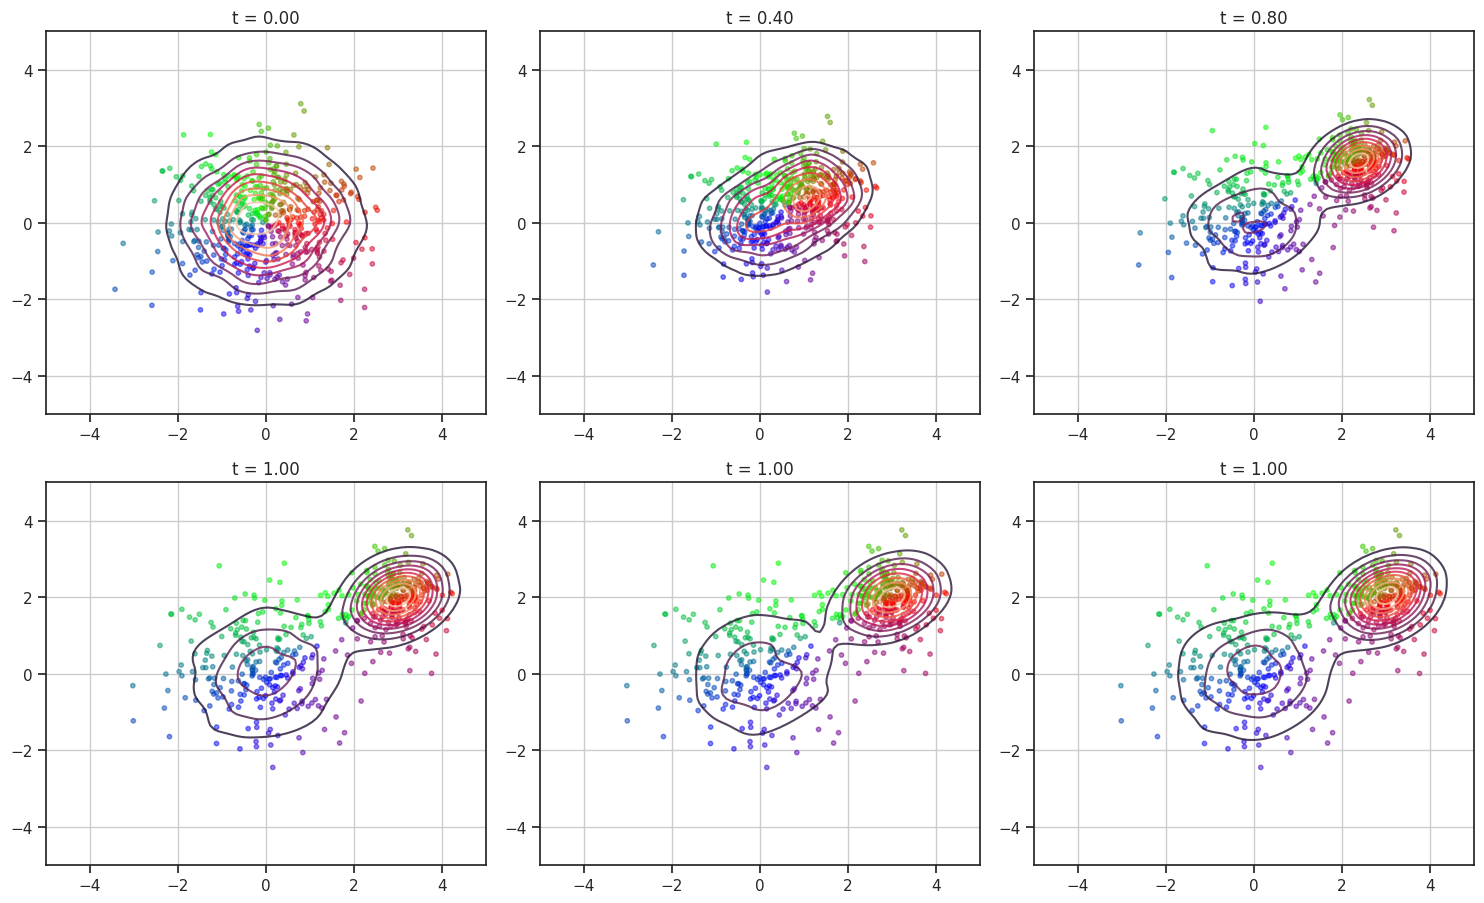

In [15]:
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
sns.set_theme(style="ticks", palette="pastel")

def get_angle_colors(positions):
    angles = np.arctan2(positions[:, 1], positions[:, 0])
    angles_deg = (np.degrees(angles) + 360) % 360
    colors = np.zeros((len(positions), 3))
    for i, angle in enumerate(angles_deg):
        segment = int(angle / 120)
        local_angle = angle - segment * 120
        if segment == 0:    # 0 degrees to 120 degrees (R->G)
            colors[i] = [1 - local_angle/120, local_angle/120, 0]
        elif segment == 1:  # 120 degrees to 240 degrees (G->B)
            colors[i] = [0, 1 - local_angle/120, local_angle/120]
        else:               # 240 degrees to 360° (B->R)
            colors[i] = [local_angle/120, 0, 1 - local_angle/120]

    return colors

# Desired time points to visualize
# desired_times = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]

desired_times = [0.0, 0.4, 0.8, 1.0, 1.2, 2.0]

# Determine indices in the trajectory corresponding to these times.
# We assume time_points is a 1D tensor of size n_steps.
time_np = time_points.detach().cpu().numpy()
n_steps = len(time_np)

# Get the index for each desired time: here we choose the index with minimum absolute difference.
indices = [np.argmin(np.abs(time_np - t_val)) for t_val in desired_times]

# Create subplots: We'll use 2 rows and 3 columns, one subplot per time.
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
axes = axes.ravel()  # flatten the 2D array for easier indexing

# Create grid for density visualization
xx, yy = np.mgrid[-5:5:100j, -5:5:100j]
positions = np.vstack([xx.ravel(), yy.ravel()])

for i, idx in enumerate(indices):
    ax = axes[i]
    # Get the samples at this time point: shape (batch, 2)
    x_t = trajectory[idx].detach().cpu().numpy()

    if i == 0:
        c = get_angle_colors(x_t)

    x_0 = mixture.sample(5000)
    t = time_np[idx]
    eps = np.random.randn(5000, 2)
    x_t_forward = t * x_0 + (1-t) * eps
    samples_ = x_t_forward

    # Compute KDE for visualization
    from scipy.stats import gaussian_kde
    kernel = gaussian_kde(samples_.T)
    density = np.reshape(kernel(positions).T, xx.shape)

    # Plot density contours
    ax.contour(xx, yy, density, levels=10, alpha=0.8)

    # Scatter plot: plot each sample as a point
    ax.scatter(x_t[:, 0], x_t[:, 1], alpha=0.5, s=10, color=c)
    ax.set_title(f"t = {time_np[idx]:.2f}")
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.grid(True)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()



This looks just like it should - both density peaks are well represented, and with _flow matching_, we now have a method at hand that yields accurate samples from the posterior with a (relatively) mild computational overhead in comparison to a deterministic model. 👍

## Summary

The **flow matching** algorithm is an important milestone in the field of diffusion models, and it concludes our trip through the history of generative modeling approaches in deep learning. Interestingly, after they were proposed, denoising, flow matching, and other variants were shown to be more similar than one would think based on the derivation. Nonetheless, they're easier to understand via their respective views on the problem, rather than from a more generic mathematical framework. Nonetheless, this field is a very exciting. We can recommend browsing recent developments online!

Nonetheless, it's time to show what these methods can do with specific and more complex examples than our GM toy problem. The following notebook will do just that. We'll start by comparing denoising diffusion models with flow matching models for a RANS airfoil task with uncertainty.